This scripts allows you to analyse the result from the cloze study.

Let's start by importing some of the packages we will use.


In [1]:
import nltk
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.metrics.distance import edit_distance as levenshtein_distance

In [2]:
import gensim.downloader as api
from gensim.parsing import preprocessing
from nltk.corpus import stopwords
from spellchecker import SpellChecker

C:\Users\fm02\AppData\Local\conda\conda\envs\py36\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


This might take a while to run, as we are downloading the word2vec model trained on Google news.

In [3]:
wv = api.load('word2vec-google-news-300')

spell = SpellChecker()

In [4]:
# we will use this function to calculate the number of non-empty responses for each target word
def length_nonempty(df_list):
    length = len(df_list)
    empties = df_list.count([""])
    return length-empties


Create two lists where to store the data from participants in group 1 and in group 2.

In [5]:
df_1List = []
df_2List = []

In [6]:
# get results for group 1 (all participants in one json file)
with open('//cbsu/data/Imaging/hauk/users/fm02/EOS_data/CLOZEresults/Group1/jatos_results_20210826185507.txt') as f:
    for jsonObj in f:
        df_1 = pd.read_json(jsonObj)
        df_1List.append(df_1)

# ... and group 2
# df = pd.read_json('U:/CLOZEresults/Group1/jatos_results_20210812170851.txt')
with open('//cbsu/data/Imaging/hauk/users/fm02/EOS_data/CLOZEresults/Group2/jatos_results_20210826140139.txt') as f:
    for jsonObj in f:
        df_2 = pd.read_json(jsonObj)
        df_2List.append(df_2)

Create one big list containing all participants.
Each pariticpant is a pd_DataFrame containing all the events in the experiment
(after the instruction alternating rows about cloze and likert(plausibility) trials)


In [7]:
dfList = [*df_1List, *df_2List]


In [8]:
# initialise some useful lists
clozeList = []
plausiList = []
bothList = []
predList = []
wordspredicted = []

save all the possible word IDs getting them from first and last participant - this is because there are different word IDs for words in group 1 and 2

In [9]:
# create a series with index = trial_id and value an empty list
# thi empty list will be populated with all the possible responses later
all_resp = pd.Series([[] for _ in range(len([*dfList[0]['ID'].dropna(),*dfList[-1]['ID'].dropna()]))],
                     index=[*dfList[0]['ID'].dropna(),*dfList[-1]['ID'].dropna()])

# drop attention checks ('ID' = 999)
all_resp = all_resp.drop(999)

# same for plausibility
all_plausib = pd.Series([[] for _ in range(len([*dfList[0]['ID'].dropna(),*dfList[-1]['ID'].dropna()]))],
                     index=[*dfList[0]['ID'].dropna(),*dfList[-1]['ID'].dropna()])
all_plausib = all_plausib.drop(999)

In [10]:
all_resp

176.0    []
290.0    []
232.0    []
187.0    []
249.0    []
         ..
364.0    []
339.0    []
426.0    []
493.0    []
395.0    []
Length: 400, dtype: object

In [11]:
all_plausib

176.0    []
290.0    []
232.0    []
187.0    []
249.0    []
         ..
364.0    []
339.0    []
426.0    []
493.0    []
395.0    []
Length: 400, dtype: object

Each dataframe in dfList contains info from the javascript cloze task in json format. We want to extract
    - response and target_word for each trial (store in clozeList)
    - plausibility value for each trial (same "ID" as the cloze task).
    
We don't care about the attention check (which all have ID=999).
Also, we accept misspelled word (i.e., we consider as misspelled each word that is has levenshtein distance <=2 from the target word).


In [12]:
# loop over each participant
for df in dfList:
   # get cloze trials
    cloze = df[df['trial_type']=='cloze']
    # keep relevant columns
    cloze = cloze[['ID','target','response']]
    # save cloze trials in the appropriate list, which will be used to calculate
    # each word's cloze probability
    clozeList.append(cloze)
    
    # save participant responses
    for index, row in cloze.iterrows():
        if row['ID']!=999: #ignore the attention checks - all participants responded well enough (already checked)
            all_resp[row['ID']].append(row['response'])
    
    # get survey-likert (aka plausibility) trials
    plausibility = df[df['trial_type']=='survey-likert']
    plausibility = plausibility[['response']]
    plausibility = plausibility.rename(columns={'response':'plausibility'})
    # assign the same ID (because it's the same order - each plausibility rating follows the order of the same)
    plausibility['ID'] = cloze['ID'].tolist()
    plausiList.append(plausibility)
    
    # save all plausibilities in one place (used to calculate average)
    for index, row in plausibility.iterrows():
        if row['ID']!=999:
            all_plausib[row['ID']].append(row['plausibility'].get('Q0'))
    
    wordpredicted = []           
    predicted = 0  
    
    # now let's count how many words did each participant predict
    # 
    for i in range(len(cloze)):
        # this includes ONLY the first word in the response:
            # accept words starting in capital
            # accepts words followed by '.' or ','
        if (cloze['target'].iloc[i] == 
            re.split(('\.| |,'),cloze['response'].iloc[i][0])[0].lower()):
            
            wordpredicted.append(cloze[['ID','target']].iloc[i])
            predicted+=1
        # accept misspelled word - counting as misspelled words with
        # levenshtein distance <=2 from the target word
        # (some words such as 'aisle' were frequently misspelled)
        else:
            if levenshtein_distance(cloze['target'].iloc[i],
                     re.split(('\.| |,'),cloze['response'].iloc[i][0])[0].lower())<=2:
                wordpredicted.append(cloze[['ID','target']].iloc[i])
                predicted+=1
    # save number of words predicted (to check each participants' performance)
    predList.append(predicted)
    # and which words were predicted
    wordspredicted.append(wordpredicted)


In [13]:
# create a dataframe where to store cloze probabilities and responses
    
get_cloze = pd.concat([df_1[['ID','target']].dropna(),df_2[['ID','target']].dropna()])
b = np.zeros(shape=(len(get_cloze),1))
get_cloze['cloze'] = b
get_cloze = get_cloze[get_cloze['ID']!=999]

In [14]:
get_cloze.sort_values(by=['ID'])

,ID,target,cloze
19,100.0,adult,0.0
165,101.0,advice,0.0
267,102.0,aisle,0.0
127,103.0,alarm,0.0
159,104.0,album,0.0
...,...,...,...
73,495.0,total,0.0
59,496.0,tune,0.0
159,497.0,value,0.0
187,498.0,venom,0.0


In [15]:
for sub in wordspredicted:
    for word in sub:
        if word['ID']!=999:
            get_cloze['cloze'].loc[get_cloze['ID']==word['ID']] +=1

get_cloze['cloze'] = get_cloze['cloze'].astype(int)

get_cloze = get_cloze.merge(all_resp.rename('all_resps'),
                            left_on='ID',right_on=all_resp.index)

# check how many non-empty responses are present for each target word
get_cloze_denominator = get_cloze['all_resps'].apply(length_nonempty) 
get_cloze['cloze'] = get_cloze['cloze'] / get_cloze_denominator


C:\Users\fm02\AppData\Local\conda\conda\envs\py36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
get_cloze.sort_values(by=['ID'])

,ID,target,cloze,all_resps
7,100.0,adult,0.875000,"[[adult], [adult], [adult], [adult], [adult], ..."
77,101.0,advice,0.693878,"[[advice], [advice], [advice], [consultations]..."
127,102.0,aisle,0.958333,"[[aisle], [aisle], [aisle], [aisle], [aisle], ..."
59,103.0,alarm,0.326531,"[[smoke], [fire alarm], [fire alarm], [fire al..."
74,104.0,album,0.755102,"[[album], [album], [album], [album], [album], ..."
...,...,...,...,...
234,495.0,total,0.000000,"[[surprise], [worst news], [answer], [result],..."
227,496.0,tune,0.300000,"[[amount], [time and location of the event], [..."
275,497.0,value,0.000000,"[[man], [guy in the car], [suspect], [suspect]..."
289,498.0,venom,0.760000,"[[venom], [venom when they bite], [poison], [v..."


In [17]:
get_cloze[get_cloze['target']=='aisle']

,ID,target,cloze,all_resps
127,102.0,aisle,0.958333,"[[aisle], [aisle], [aisle], [aisle], [aisle], ..."


As we can see, the cloze probability of the word is quite high (.96). I believe we should include include misspelled words as, some words, such as 'aisle' were quite frequently misspelled as evident when checking each participant response. If we do not include them, the probability would drop.


In [18]:
get_cloze['all_resps'][get_cloze['target']=='aisle'].to_list()

[[['aisle'],
  ['aisle'],
  ['aisle'],
  ['aisle'],
  ['aisle'],
  ['aisle'],
  ['aisle'],
  ['aisle'],
  ['isle'],
  ['aile'],
  ['aisle'],
  ['isle.'],
  ['alter'],
  ['isle'],
  ['aisle'],
  ['aisle'],
  ['aisle to her bride'],
  ['aisle'],
  ['aisle'],
  ['aisle with her father'],
  ['aisle with her Dad'],
  ['isle'],
  ['aisle'],
  ['aisle'],
  ['aisle'],
  ['aisle'],
  ['aisle'],
  ["motorway because that was a better choice than getting married to a man she didn't love"],
  ['aisle with her  father'],
  ['aisle'],
  ['aisle'],
  ['isle'],
  ['isle'],
  ['aisle with her father.'],
  ['aisle of the church.'],
  ['isle'],
  ['isle'],
  ['aisle'],
  ['isle'],
  ['aisle'],
  [''],
  ['isle to her soon to be husband'],
  ['aisle'],
  ['aisle'],
  ['aisle'],
  ['isle'],
  ['aisle'],
  ['aisle'],
  ['aisle']]]

In [19]:
# add 1 to each value because start counting from 0, but the likert that was displayed started from 1 (to 7)
all_plausib = all_plausib = pd.Series([np.array(x)+1 for x in all_plausib],index=all_plausib.index)
all_plausib = all_plausib.apply(np.mean) # return the mean for each target word


In [20]:
get_cloze = get_cloze.merge(all_plausib.rename('plausibility'),
                            left_on='ID',right_on=all_resp.index)
get_cloze.sort_values(by=['ID']).head(10)

,ID,target,cloze,all_resps,plausibility
7,100.0,adult,0.875000,"[[adult], [adult], [adult], [adult], [adult], ...",6.408163
77,101.0,advice,0.693878,"[[advice], [advice], [advice], [consultations]...",5.877551
127,102.0,aisle,0.958333,"[[aisle], [aisle], [aisle], [aisle], [aisle], ...",6.693878
59,103.0,alarm,0.326531,"[[smoke], [fire alarm], [fire alarm], [fire al...",6.367347
74,104.0,album,0.755102,"[[album], [album], [album], [album], [album], ...",6.306122
147,105.0,appeal,0.489796,"[[appeal], [event fundraiser], [appeal], [appe...",6.142857
118,106.0,apron,0.458333,"[[apron], [apron], [apron], [apron], [apron], ...",5.979592
68,107.0,armour,0.520833,"[[armour], [armoured vest], [armour], [armour]...",6.183673
126,108.0,aspect,0.000000,"[[family], [person, directly or indirectly], [...",6.000000
30,109.0,attack,0.000000,"[[comments], [claims], [article], [review], [c...",5.469388


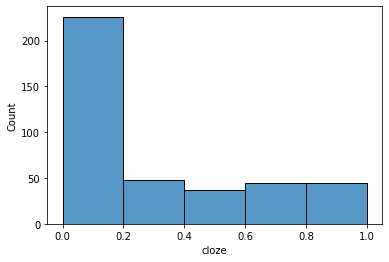

In [21]:
plt.subplots()
sns.histplot(data=get_cloze,x='cloze',bins=5);


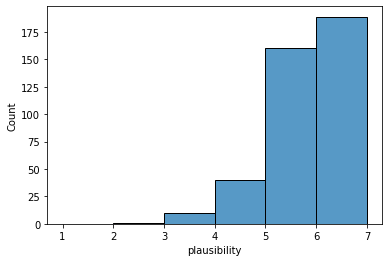

In [22]:
plt.subplots()
sns.histplot(data=get_cloze,x='plausibility',bins=[1,2,3,4,5,6,7]);


In [23]:
print(f"The number of sentences with an average plausibility less than 5 is: ", len(get_cloze[get_cloze['plausibility']<5]))
print(f"The number of sentences with an average plausibility less than 4 is: ", len(get_cloze[get_cloze['plausibility']<4]))
print(f"The number of sentences with an average plausibility less than 3 is: ", len(get_cloze[get_cloze['plausibility']<3]))

The number of sentences with an average plausibility less than 5 is:  51
The number of sentences with an average plausibility less than 4 is:  11
The number of sentences with an average plausibility less than 3 is:  1


In [24]:
# check participants based on number of words predicted
minimum_predicted = np.mean(np.array(predList))-2*(np.std(np.array(predList)))
to_exclude = [(idx, x) for idx, x in enumerate(predList) if x<minimum_predicted]

In [25]:
to_exclude, minimum_predicted

([(27, 24), (40, 37)], 44.70791764018047)

We might decided to exclude participants who predicted less than 2 SD than average, in terms of how many words they predicted.
Indeed, participant 27 responses were often inappropriate when checked manually (e.g., complaining about the task, rather than performing the task), and they predicted only 24 words (considering that 44.7 answers is 2 SD away from the mean). Participant 40 predicted 37 words, but very often left the response box empty (i.e., no response given - I guess to speed up the experiment).

So, the cell below analysis data excluding participant 27 an 40, based on the above considerations.
(This is the content presente in the script "ClozeAnalysis.py".

C:\Users\fm02\AppData\Local\conda\conda\envs\py36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


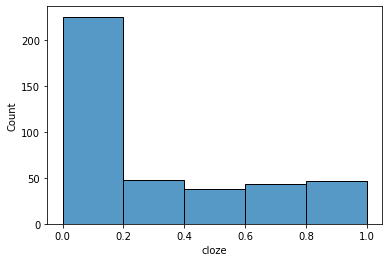

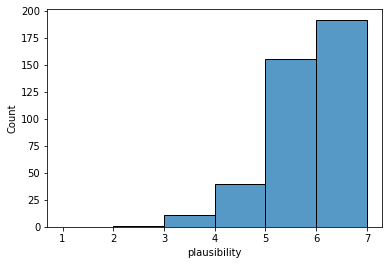

In [26]:
exclude = [27, 40]

# we will use this function to calculate the number of non-empty responses for each target word
def length_nonempty(df_list):
    length = len(df_list)
    empties = df_list.count([""])
    return length-empties

# save temporarily participants data in two different lists, corresponding to the two groups
# easier to incorprorate them in one big list later
df_1List = []
df_2List = []

# get results for group 1 (all participants in one json file)
# with open('C:/Users/fm02/OwnCloud/ClozeTask_sharedfolder/CLOZEresults/Group1/jatos_results_20210826185507.txt') as f:
with open('//cbsu/data/Imaging/hauk/users/fm02/EOS_data/CLOZEresults/Group1/jatos_results_20210826185507.txt') as f:
    for jsonObj in f:
        df_1 = pd.read_json(jsonObj)
        df_1List.append(df_1)

# ... and group 2
#with open('C:/Users/fm02/OwnCloud/ClozeTask_sharedfolder/CLOZEresults/Group2/jatos_results_20210826140139.txt') as f:
with open('//cbsu/data/Imaging/hauk/users/fm02/EOS_data/CLOZEresults/Group2/jatos_results_20210826140139.txt') as f:
    for jsonObj in f:
        df_2 = pd.read_json(jsonObj)
        df_2List.append(df_2)


# Create one big list containing all participants.
# Each pariticpant is a pd_DataFrame containing all the events in the experiment
# (after the instruction alternating rows about cloze and likert(plausibility) trials)
# 

dfList = [*df_1List, *df_2List]

for ex in exclude:
    dfList.pop(ex)

# initialise some useful lists

# in this list we will save each participant responses to the cloze task
clozeList = []
# in this plausibility ratings
plausiList = []
# here we save the number of words predicted fro each participant 
# (to check performance)
predList = []
# here we save each word correctly predicted by the participants
wordspredicted = []

# save all the possible word IDs getting them from first and last participant - this is because there are different word IDs for words in group 1 and 2

# this creates a Series, with index=IDs, and each value as an empty list
# thi empty list will be populated with all the possible responses later
all_resp = pd.Series([[] for _ in range(len([*dfList[0]['ID'].dropna(),*dfList[-1]['ID'].dropna()]))],
                     index=[*dfList[0]['ID'].dropna(),*dfList[-1]['ID'].dropna()])

# drop attention checks ('ID' = 999)
all_resp = all_resp.drop(999)

# same for plausibility
all_plausib = pd.Series([[] for _ in range(len([*dfList[0]['ID'].dropna(),
                                                *dfList[-1]['ID'].dropna()]))],
                     index=[*dfList[0]['ID'].dropna(),
                            *dfList[-1]['ID'].dropna()])
all_plausib = all_plausib.drop(999)

# loop over each participant
for df in dfList:
    # get cloze trials
    cloze = df[df['trial_type']=='cloze']
    # keep relevant columns
    cloze = cloze[['ID','target','response']]
    # save cloze trials in the appropriate list, which will be used to calculate
    # each word's cloze probability
    clozeList.append(cloze)
    
    # save participant responses
    for index, row in cloze.iterrows():
        if row['ID']!=999: #ignore the attention checks - all participants responded well enough (already checked)
            all_resp[row['ID']].append(row['response'])
    
    # get survey-likert (aka plausibility) trials
    plausibility = df[df['trial_type']=='survey-likert']
    plausibility = plausibility[['response']]
    plausibility = plausibility.rename(columns={'response':'plausibility'})
    # assign the same ID (because it's the same order - each plausibility rating follows the order of the same)
    plausibility['ID'] = cloze['ID'].tolist()
    plausiList.append(plausibility)
    
    # save all plausibilities in one place (used to calculate average)
    for index, row in plausibility.iterrows():
        if row['ID']!=999:
            all_plausib[row['ID']].append(row['plausibility'].get('Q0'))
    
    wordpredicted = []           
    predicted = 0  
    
    # now let's count how many words did each participant predict
    # 
    for i in range(len(cloze)):
        # this includes ONLY the first word in the response:
            # accept words starting in capital
            # accepts words followed by '.' or ','
        if (cloze['target'].iloc[i] == 
            re.split(('\.| |,'),cloze['response'].iloc[i][0])[0].lower()):
            
            wordpredicted.append(cloze[['ID','target']].iloc[i])
            predicted+=1
        # accept misspelled word - counting as misspelled words with
        # levenshtein distance <=2 from the target word
        # (some words such as 'aisle' were frequently misspelled)
        else:
            if levenshtein_distance(cloze['target'].iloc[i],
                     re.split(('\.| |,'),cloze['response'].iloc[i][0])[0].lower())<=2:
                wordpredicted.append(cloze[['ID','target']].iloc[i])
                predicted+=1
    # save number of words predicted (to check each participants' performance)
    predList.append(predicted)
    # and which words were predicted
    wordspredicted.append(wordpredicted)

# create a dataframe where to store cloze probabilities and responses
    
get_cloze = pd.concat([df_1[['ID','target']].dropna(),df_2[['ID','target']].dropna()])
get_cloze['cloze'] = np.zeros(shape=(len(get_cloze),1))
get_cloze = get_cloze[get_cloze['ID']!=999]

for sub in wordspredicted:
    for word in sub:
        if word['ID']!=999:
            get_cloze['cloze'].loc[get_cloze['ID']==word['ID']] +=1

get_cloze['cloze'] = get_cloze['cloze'].astype(int)

get_cloze = get_cloze.merge(all_resp.rename('all_resps'),
                            left_on='ID',right_on=all_resp.index)

# check how many non-empty responses are present for each target word
get_cloze_denominator = get_cloze['all_resps'].apply(length_nonempty) 
get_cloze['cloze'] = get_cloze['cloze'] / get_cloze_denominator

# add 1 to each value because start counting from 0, but the likert that was displayed started from 1 (to 7)
all_plausib = pd.Series([np.array(x)+1 for x in all_plausib], index=all_plausib.index)
all_plausib = all_plausib.apply(np.mean) # return the mean for each target word

get_cloze = get_cloze.merge(all_plausib.rename('plausibility'),
                            left_on='ID',right_on=all_resp.index)

plt.subplots()
sns.histplot(data=get_cloze,x='cloze',bins=5);

plt.subplots()
sns.histplot(data=get_cloze,x='plausibility',bins=[1,2,3,4,5,6,7]);


Now let's look how cloze fits with the previous words characteristics.
We import info about the words and the sentences

In [27]:
stimuli = pd.read_excel('//cbsu/data/Imaging/hauk/users/fm02/EOS_data/Stimuli/stimuli_all_onewordsemsim.xlsx', engine='openpyxl',
                        usecols=['ID',
                                 'Word',
                                 'Sentence',
                                 'ConcM',
                                 'LEN', 
                                 'UN2_F', 
                                 'UN3_F', 
                                 'Orth', 
                                 'OLD20',
                                 'FreqCount', 
                                 'LogFreq(Zipf)', 
                                 'V_MeanSum',
                                 'A_MeanSum', 
                                 'mink3_SM', 
                                 'Position',
                                 'BLP_rt',
                                 'BLP_accuracy', 
                                 'similarity',
                                 'PRECEDING_Frequency', 
                                 "PRECEDING_LogFreq(Zipf)", 
                                 "LENprec",
                                 'AoA', 
                                 'Predictability'])

Merge the results from cloze and plausibility.

In [28]:
stimuli = stimuli.merge(get_cloze[['cloze','plausibility']],
                        left_on='Word',right_on=get_cloze['target'])

In [29]:
stimuli.head()

,ID,Word,ConcM,V_MeanSum,A_MeanSum,mink3_SM,Sentence,Predictability,BLP_rt,BLP_accuracy,...,FreqCount,LogFreq(Zipf),similarity,AoA,Position,PRECEDING_Frequency,PRECEDING_LogFreq(Zipf),LENprec,cloze,plausibility
0,100,absence,2.31,3.86,4.30,3.974638,The school called because of the student's una...,0,568.75,1.00,...,1558,3.89,0.062656,7.70,9,301,3.18,12,0.76000,6.460000
1,101,accent,3.26,6.48,4.95,4.940823,People from Birmingham have the most recogniza...,0,547.15,1.00,...,2884,4.16,0.124462,8.60,8,11,1.77,12,0.94000,5.500000
2,102,access,2.71,6.68,5.30,3.967939,Men and women should have equal access to educ...,1,585.97,0.98,...,11333,4.75,0.057037,9.10,7,4090,4.31,5,0.00000,6.540000
3,103,action,2.86,6.00,6.19,6.226654,It is time to turn ideas into action and make ...,0,518.13,1.00,...,24959,5.09,0.164773,6.67,8,288299,6.16,4,0.44000,6.140000
4,104,adult,4.40,5.90,4.36,4.841120,Anyone over eighteen years of age counts as an...,0,497.90,1.00,...,5099,4.40,0.235083,4.68,10,504518,6.40,2,0.87234,6.446809


As word2vec dictionary is in US spelling rather than UK, we might want to trasform them.
In this .csv files are listed a huge number of transformation, we hope to capture all that are also present in our dataset.

In [30]:
df = pd.read_csv('C:/Users/fm02/OwnCloud/ClozeTask_sharedfolder/UK2US.csv',sep=';')
UK2US_dict = pd.Series(df.US.values,index=df.UK).to_dict()
US2UK_dict = pd.Series(df.UK.values,index=df.US).to_dict()

def replace_all(text):
    for i,w in enumerate(text):
        if w in UK2US_dict:
            text[i] = UK2US_dict[w]
    return text

This should be unnecessary now, but in case there's an error, just uncomment it.

In [31]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [32]:
def clean_resp(resps):
    """This function checks that responses are ready to be fed to word2vec."""
    # import stopwords (aka very-high-freq words) from nltk
    stop_words = set(stopwords.words('english')) 
    all_trials = []
    # loop over all trials(i.e., wordIDs)
    for i,trial in enumerate(resps):
        # check at what point are we at (400 words)
        print(i)
        new_trial = []
        # loop over responses (from different participants), so that wach s is the response by one participant        
        for s in trial:           
            # convert list (each response is contained inside a list) to string
            s = str(s[0])
            s = s.lower()
            s = preprocessing.strip_punctuation(s)
            s = preprocessing.strip_numeric(s)
            # using stop words from nltk because too many in gensim stop_word, including target words
            s = nltk.word_tokenize(s)
            s = replace_all(s)
            # (re)create a list of words for each response
            s = [word for word in s if not word in stop_words]
            # find words of unknown spelling
            misspelled = spell.unknown(s)
            # as similarity works only with words of known spelling, try to correct all words
            for i,w in enumerate(s):
                if w in misspelled:
                    # try to correct misspelled words
                    s[i] = spell.correction(w)
                # if a word is not included in w2v dictionary drop it
                # or w2v will throw an error
                if not(wv.has_index_for(s[i])): 
                        s[i] = ''
            if s!=['']:
                new_trial.append(s)
    
        all_trials.append(new_trial)   
        
    return all_trials

In [33]:
responses = get_cloze['all_resps']
targets = replace_all(get_cloze['target'])

# prepare responses to be analysed in w2v (consider that w2v is US not UK)
tok = clean_resp(responses)

C:\Users\fm02\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [34]:
word_similarities = pd.DataFrame(index=np.arange(400),columns=['Word','Sim'])
word_similarities['Word']=targets

In [35]:
# for each trial (i.e., wordID)
for i,t in enumerate(tok):
    similarities = []
    # for each response in that trial
    for list_words in t:
        # check this is not empty
        if list_words:
            # calculare similarities with target word and append the word that
            # is most similar to the target word.
            similarities.append(max([wv.similarity(w,targets[i])
                                     for id_w,w in enumerate(list_words)
                                     if wv.has_index_for(w)]))
    # calculate now the average similarity between responses and the target word
    # this is our measure of CLOZE SEMANTIC SIMILARITY
    word_similarities['Sim'].loc[word_similarities['Word']==targets[i]] = np.mean(similarities)

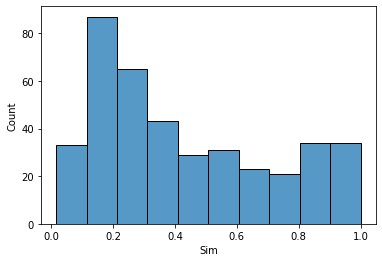

In [36]:
plt.subplots()
sns.histplot(data=word_similarities,x='Sim',bins=10);

In [37]:
for target in targets:
    if target in US2UK_dict:
        word_similarities['Word'][word_similarities['Word']==target] = US2UK_dict[target]

Attach cloze semantic similarity for each word to the main dataframe.

In [38]:
corrStimuli2 = pd.merge(stimuli,word_similarities, on='Word' )

In [39]:
# corrStimuli2.to_excel('C:/Users/User/OwnCloud/Sentences/stimuli_all_onewordsemsim.xlsx',index=False)

Select only the numeric variables (e.g., no words ID or sentence), and calculare intercorrelation matrix

In [40]:
corrStimuli2 = corrStimuli2[['ConcM', 
                             'LEN', 
                             'UN2_F', 
                             'UN3_F', 
                             'Orth', 
                             'OLD20',
                             'FreqCount', 
                             'LogFreq(Zipf)', 
                             'V_MeanSum',
                             'A_MeanSum', 
                             'mink3_SM', 
                             'Position',
                             'BLP_rt', 
                             'BLP_accuracy', 
                             'similarity',  
                             'PRECEDING_Frequency', 
                             "PRECEDING_LogFreq(Zipf)", 
                             "LENprec",
                             'Predictability',
                             'cloze',
                             'plausibility',
                             'Sim']]
corrStimuli2['Sim'] = pd.to_numeric(corrStimuli2['Sim'])
corrmat2 = corrStimuli2.corr()

Change name so they are less obscure

In [41]:
corrmatlabels2 = ["Concreteness", 
                 "#letters", 
                 "BigramFreq", 
                 "TrigramFreq", 
                 "OrthN",
                 "OLD20",
                 "Frequency", 
                 "LogFreq(Zipf)", 
                 "Valence", 
                 "Arousal", 
                 "SensorimotorStrength", 
                 "PositionSent",
                 "BLP_rt",
                 "BLP_accuracy",
                 "CONTEXT Semantic Similarity",
                 "PRECEDING_Frequency",
                 "PRECEDING_LogFreq(Zipf)",
                 "PRECEDING_#letters",
                 "Apriori_Predictability",
                 "Cloze_Probability",
                 "Plausibility",
                 "CLOZE Semantic Similarity"
                 ]    

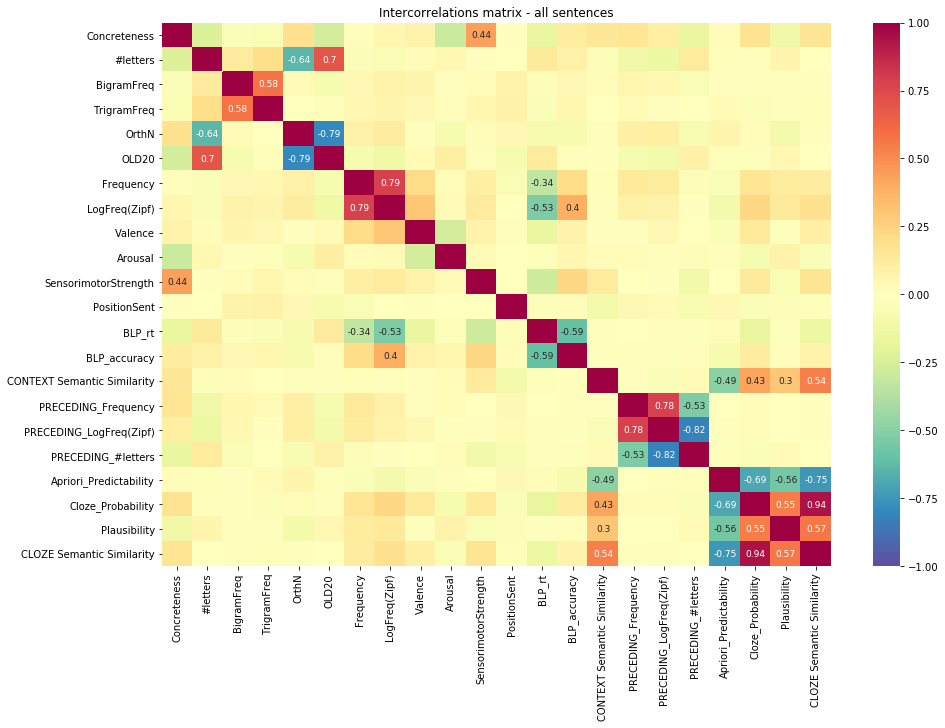

In [42]:
# in heatmap, indicate exact number in correlations >0.3
labelscorrmat2 = corrmat2.applymap(lambda v: str(round(v,2)) if (1 > abs(v) > 0.3) else '')
plt.subplots(1, 1, figsize = (15, 10))  

sns.heatmap(corrmat2, cmap="Spectral_r", annot=labelscorrmat2, 
            annot_kws={'fontsize':9}, fmt='', vmin=-1, vmax=1,
            xticklabels=corrmatlabels2,
            yticklabels=corrmatlabels2)
plt.title("Intercorrelations matrix - all sentences")

plt.show()
 